In [1]:
import sys
from pathlib import Path

root_dir = Path().absolute()
# Strip subdirectory if notebook started inside project subfolders
if root_dir.parts[-1:] == ('airquality',):
    root_dir = Path(*root_dir.parts[:-1])
if root_dir.parts[-1:] == ('notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
if root_dir.parts[-1:] == ('local_notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
if root_dir.parts[-1:] == ('collab_notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
root_dir = str(root_dir) 
print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from airquality.config import HopsworksSettings
settings = HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learning
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from airquality import util
import json
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 14:48:09,859 INFO: Initializing external client
2025-11-18 14:48:09,859 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 14:48:11,428 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279132


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])
lagged_features = air_quality_fg.select(['pm25', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'city', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-18 14:48:13,808 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
2025-11-18 14:48:13,808 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [6]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=2,
    labels=['pm25'],
    query=selected_features,
)

lagged_feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv_lagged',
    description="weather features with air quality as the target",
    version=1,  # Changed version since schema changed
    labels=['pm25'],
    query=lagged_features,  # Changed to use lagged_features
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [7]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

X_lagged_train, X_lagged_test, y_lagged_train, y_lagged_test = lagged_feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.66s) 


In [9]:
X_train
X_lagged_train

,pm25_lag1,pm25_lag2,pm25_lag3,city,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,10.0,9.0,16.0,skelleftea-kv-pantern,2022-09-05 00:00:00+00:00,10.292583,0.0,13.708391,271.641754
1,16.0,10.0,9.0,skelleftea-kv-pantern,2022-09-06 00:00:00+00:00,10.073833,0.0,15.986595,337.105988
2,13.0,16.0,10.0,skelleftea-kv-pantern,2022-09-07 00:00:00+00:00,8.223833,0.0,13.608762,21.019268
3,7.0,13.0,16.0,skelleftea-kv-pantern,2022-09-08 00:00:00+00:00,8.798833,0.0,12.496718,224.043762
4,20.0,7.0,13.0,skelleftea-kv-pantern,2022-09-09 00:00:00+00:00,11.280084,0.0,16.279802,221.653076
...,...,...,...,...,...,...,...,...,...
738,30.0,31.0,30.0,skelleftea-kv-pantern,2025-04-26 00:00:00+00:00,-0.340750,0.0,15.934829,79.731743
739,15.0,30.0,31.0,skelleftea-kv-pantern,2025-04-27 00:00:00+00:00,4.611333,0.0,11.103243,230.093018
740,22.0,15.0,30.0,skelleftea-kv-pantern,2025-04-28 00:00:00+00:00,7.880085,2.7,15.655861,267.248077
741,41.0,22.0,15.0,skelleftea-kv-pantern,2025-04-29 00:00:00+00:00,2.107167,0.1,18.337044,44.222839


In [10]:
X_train['city'] = X_train["city"].astype("category")
X_test['city'] = X_test["city"].astype("category")
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

X_lagged_train['city'] = X_lagged_train["city"].astype("category")
X_lagged_test['city'] = X_lagged_test["city"].astype("category")
X_lagged_features = X_lagged_train.drop(columns=['date'])
X_lagged_test_features = X_lagged_test.drop(columns=['date'])

# Drop NaNs from train set
train_df = pd.concat([X_train, y_train], axis=1).dropna()
X_train = train_df.drop(columns=['pm25'])
y_train = train_df[['pm25']]

# Drop NaNs from test set
test_df = pd.concat([X_test, y_test], axis=1).dropna()
X_test = test_df.drop(columns=['pm25'])
y_test = test_df[['pm25']]

X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [11]:
y_train

,pm25
0,16.0
1,13.0
2,7.0
3,20.0
4,17.0
...,...
738,15.0
739,22.0
740,41.0
741,22.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [12]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(
    enable_categorical=True,
    tree_method="hist",
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)
xgb_lagged_regressor = XGBRegressor(
    enable_categorical=True,
    tree_method="hist",
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)
xgb_lagged_regressor.fit(X_lagged_features, y_lagged_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [13]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)
y_lagged_pred_test = xgb_lagged_regressor.predict(X_lagged_test_features)


# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

lagged_mse = mean_squared_error(y_lagged_test.iloc[:,0], y_lagged_pred_test)
print("Lagged MSE:", lagged_mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)
lagged_r2 = r2_score(y_lagged_test.iloc[:,0], y_lagged_pred_test)
print("Lagged R squared:", lagged_r2)

MSE: 72.61515045166016
Lagged MSE: 82.88121795654297
R squared: 0.5381709337234497
Lagged R squared: 0.4728800058364868


In [14]:
df = y_test
df['predicted_pm25'] = y_pred

In [15]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])

lagged_df = y_lagged_test
lagged_df['city'] = X_lagged_test['city']
lagged_df['date'] = X_lagged_test['date']
lagged_df['predicted_pm25'] = y_lagged_pred_test

df.head(5)
lagged_df.head(5)

,pm25,city,date,predicted_pm25
743,24.0,skelleftea-kv-pantern,2025-05-01 00:00:00+00:00,31.177380
744,20.0,skelleftea-kv-pantern,2025-05-02 00:00:00+00:00,19.319925
745,10.0,skelleftea-kv-pantern,2025-05-03 00:00:00+00:00,14.598529
746,13.0,skelleftea-kv-pantern,2025-05-04 00:00:00+00:00,16.741613
747,19.0,skelleftea-kv-pantern,2025-05-05 00:00:00+00:00,17.596731


In [16]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

lagged_model_dir = f"air_quality_model"
if not os.path.exists(lagged_model_dir):
    os.mkdir(lagged_model_dir)
lagged_images_dir = lagged_model_dir + "/images"
if not os.path.exists(lagged_images_dir):
    os.mkdir(lagged_images_dir)

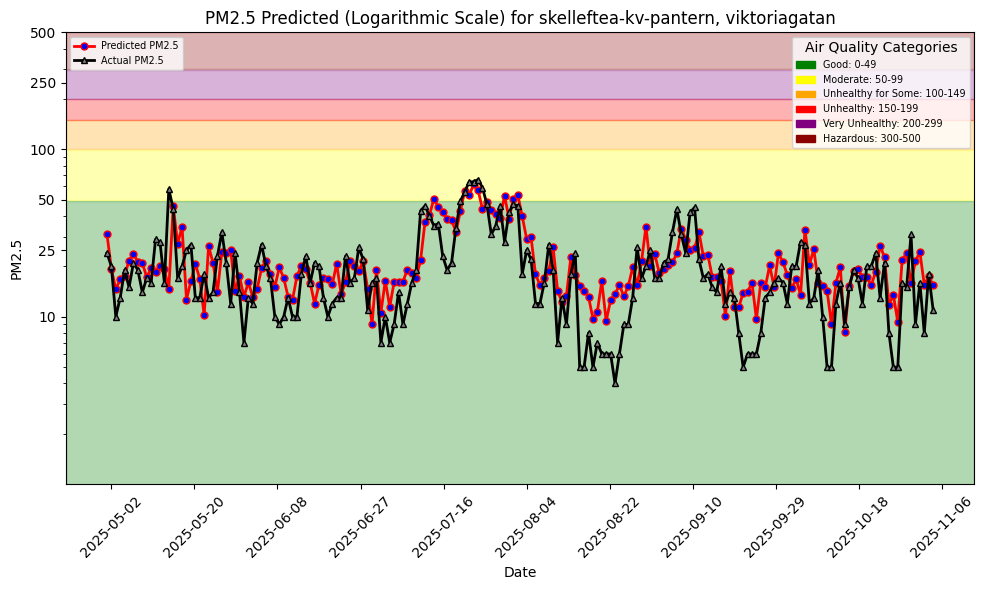

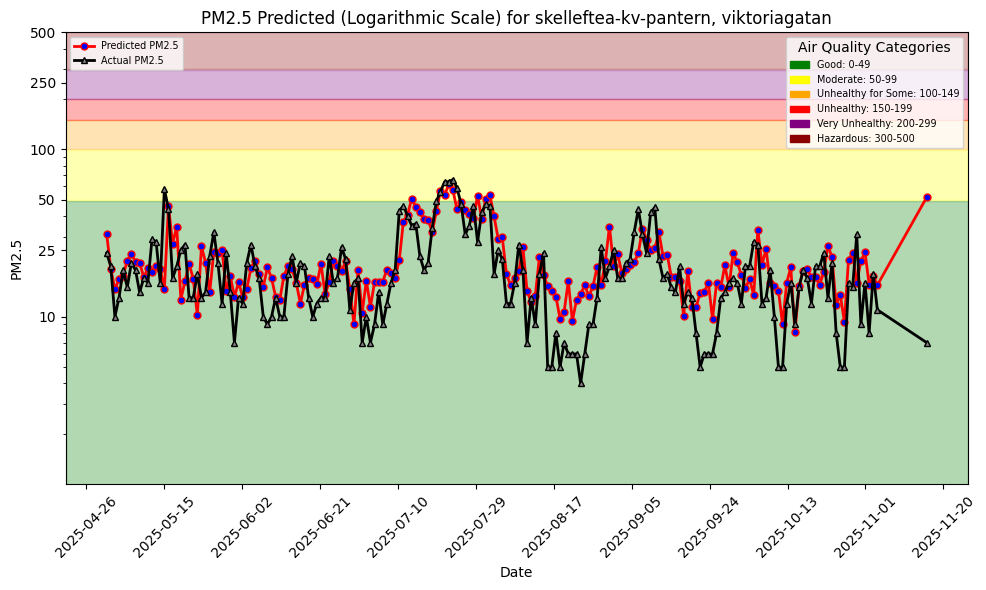

In [17]:
file_path = images_dir + "/pm25_hindcast.png"
lagged_file_path = lagged_images_dir + f"/pm25_hindcast.png"

plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

lagged_plt = util.plot_air_quality_forecast(city, street, lagged_df, lagged_file_path, hindcast=True) 
plt.show()

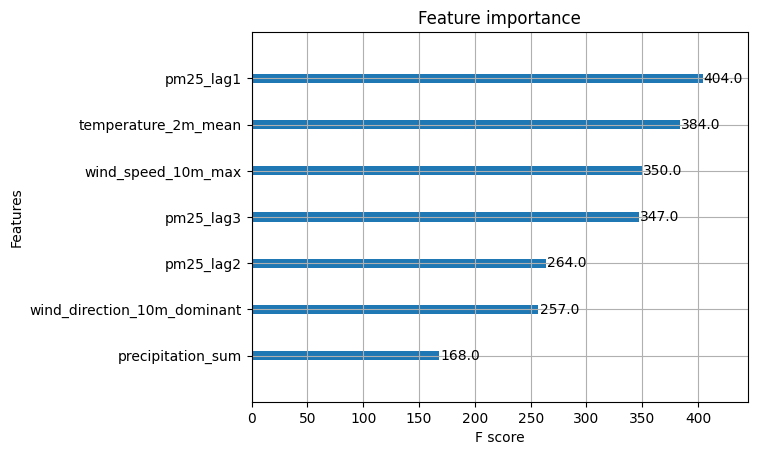

In [18]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
lagged_feature_importance_path = lagged_images_dir + f"/feature_importance.png"

plt.savefig(feature_importance_path)
lagged_plt.savefig(lagged_feature_importance_path)

plt.show()
lagged_plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [19]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")
xgb_lagged_regressor.save_model(lagged_model_dir + f"/model.json")

In [20]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

lagged_res_dict = { 
        "MSE": str(lagged_mse),
        "R squared": str(lagged_r2),
    }

In [21]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

lagged_aq_model = mr.python.create_model(
    name=f"air_quality_xgboost_lagged_model", 
    metrics= lagged_res_dict,
    feature_view=lagged_feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)
lagged_aq_model.save(lagged_model_dir)


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279132/models/air_quality_xgboost_model/7


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279132/models/air_quality_xgboost_lagged_model/1


Model(name: 'air_quality_xgboost_lagged_model', version: 1)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.


# WAIT, there's more...

## A-grade: create model for each of the sensors
We need to make sure to execute the above cells for each of the sensors that we can find in the Skelleftea area 

Checking data folder structure at path: /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learning/data/extra_sensors
Data folder structure is correct.
2025-11-18 14:49:05,895 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 14:49:05,907 INFO: Initializing external client
2025-11-18 14:49:05,907 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 14:49:07,484 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279132
Processing extra sensor data from file: ac846-skelleftea.csv
2025-11-18 14:49:08,447 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 14:49:08,451 INFO: Initializing external client
2025-11-18 14:49:08,452 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 14:49:10,056 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279132
2025-11-18 14:49:12,526 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_ac846_skelleftea` as features for the query. To include primary key and event time use `select_all`.
2025-11-18 14:49:12,527 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_ac846_skelleftea` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.65s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.06s) 
MSE: 104.16157531738281
Lagged MSE: 31.03069305419922
R squared: -0.5060999393463135
Lagged R squared: 0.5365536212921143
Using city and street from secrets.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Uploading /Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learnin…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279132/models/air_quality_xgboost_model_ac846_skelleftea/13


  0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while processing extra sensors: [Errno 2] No such file or directory: '/Users/oscarreinagustafsson/Desktop/Projects/Master/machine-learning/ID2223-scalable-machine-learning/local_notebooks/air_quality_model_ac846_skelleftea/lagged/model_ac846_skelleftea.json'


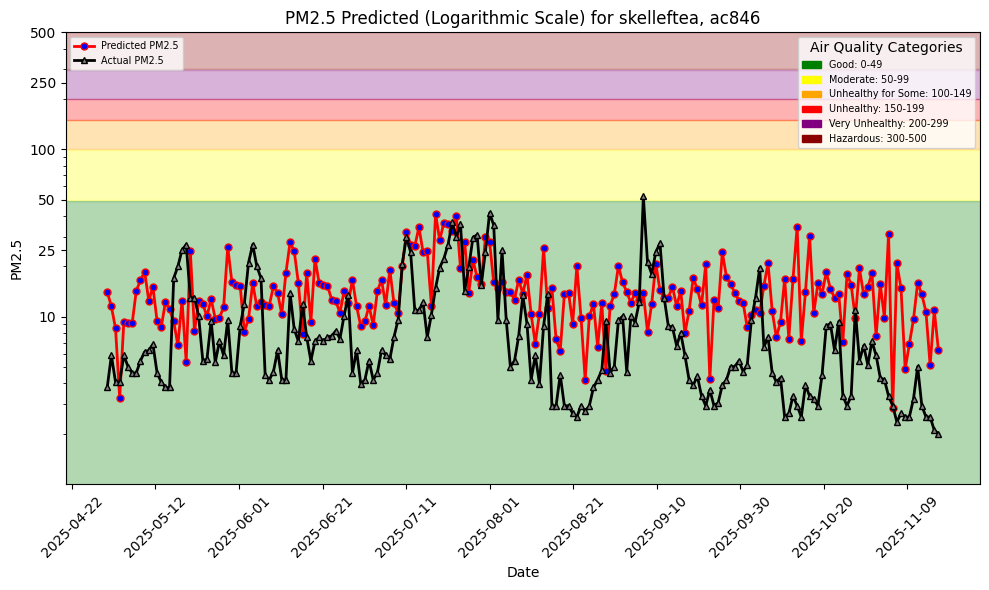

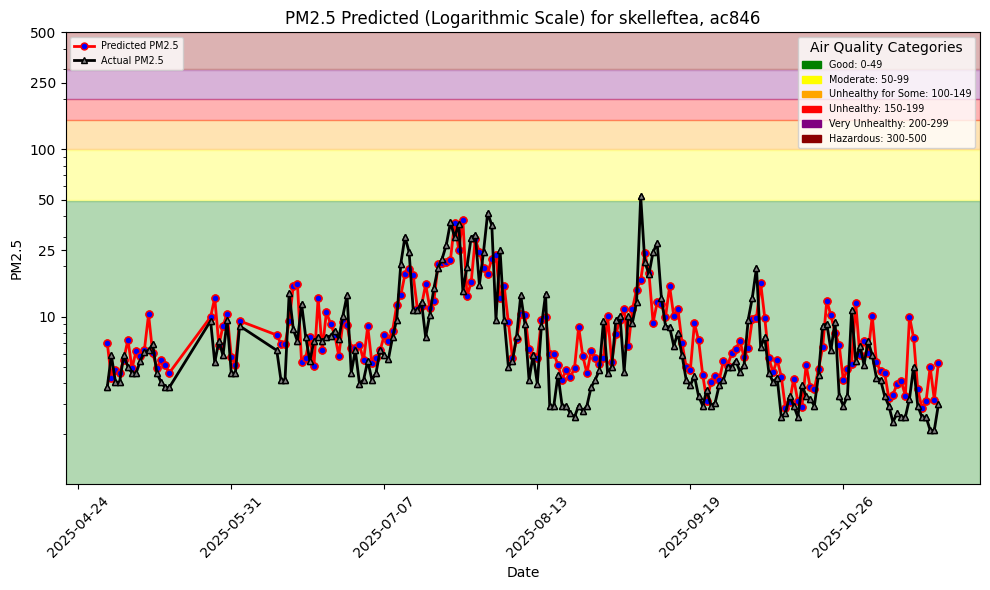

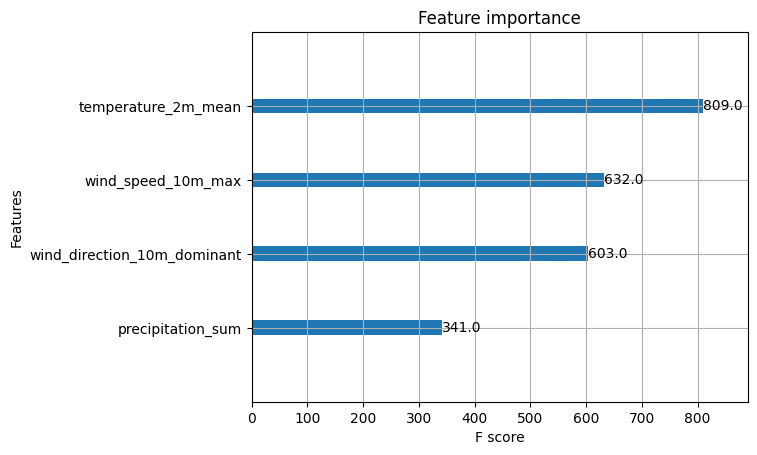

In [22]:
try:
    extra_sensors = f"{root_dir}/data/extra_sensors/"
    util.check_data_folder_structure(root_dir)

    project = hopsworks.login()
    fs = project.get_feature_store() 
    secrets = hopsworks.get_secrets_api()

    import json

    try:
        with open(f"{root_dir}/data/extra_sensor_settings.json", 'r') as file:
            settings_json = json.load(file)["extra_sensors"]
    except FileNotFoundError:
        print("Settings file for extra sensors not found.")
        sys.exit(1)

    for csv_file_name in os.listdir(extra_sensors):

        print(f"Processing extra sensor data from file: {csv_file_name}")
        if settings.HOPSWORKS_API_KEY is not None:
            api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
            os.environ['HOPSWORKS_API_KEY'] = api_key
        project = hopsworks.login()
        fs = project.get_feature_store() 

        secrets = hopsworks.get_secrets_api()
        location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{csv_file_name}").value
        location = json.loads(location_str)
        country=location['country']
        city=location['city']
        street=location['street']


        ####################
        import re
        ####################
        # Retrieve feature groups
        # split the .csv extension from the csv_file_name: not compatible with Hopsworks feature group names
        csv_file_name_no_ext = os.path.splitext(csv_file_name)[0]
        # replace - with _
        csv_file_name_no_ext = re.sub(r'[-\s]', '_', csv_file_name_no_ext)

        air_quality_fg = fs.get_feature_group(
            name=f'air_quality_{csv_file_name_no_ext}',
            version=2,
        )
        weather_fg = fs.get_feature_group(
            name=f'weather_{csv_file_name_no_ext}',
            version=1,
        )

        # Select features for training data.
        selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])
        lagged_features = air_quality_fg.select(['pm25', 'lagged_1', 'lagged_2', 'lagged_3', 'city', 'date']).join(weather_fg.select_features(), on=['city'])

        feature_view = fs.get_or_create_feature_view(
            name=f'air_quality_fv_{csv_file_name_no_ext}',
            description="weather features with air quality as the target",
            version=1,
            labels=['pm25'],
            query=selected_features,
        )

        lagged_feature_view = fs.get_or_create_feature_view(
            name=f'air_quality_lagged_fv_{csv_file_name_no_ext}',
            description="features with air quality as the target (including lagged air quality)",
            version=1,
            labels=['pm25'],
            query=lagged_features,
        )

        start_date_test_data = "2025-05-01"
        # Convert string to datetime object
        test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

        X_train, X_test, y_train, y_test = feature_view.train_test_split(
            test_start=test_start
        )

        X_lagged_train, X_lagged_test, y_lagged_train, y_lagged_test = lagged_feature_view.train_test_split(
            test_start=test_start
        )

        X_lagged_train['city'] = X_lagged_train["city"].astype("category")
        X_lagged_test['city'] = X_lagged_test["city"].astype("category")
        X_lagged_features = X_lagged_train.drop(columns=['date'])
        X_lagged_test_features = X_lagged_test.drop(columns=['date'])

        # Drop NaNs from train set
        train_df = pd.concat([X_train, y_train], axis=1).dropna()
        X_train = train_df.drop(columns=['pm25'])
        y_train = train_df[['pm25']]

        # Drop NaNs from test set
        test_df = pd.concat([X_test, y_test], axis=1).dropna()
        X_test = test_df.drop(columns=['pm25'])
        y_test = test_df[['pm25']]

        X_features = X_train.drop(columns=['date'])
        X_test_features = X_test.drop(columns=['date'])

        # Creating an instance of the XGBoost Regressor
        xgb_regressor = XGBRegressor(
            enable_categorical=True,
            tree_method="hist",
            max_depth=5,
            learning_rate=0.1,
            n_estimators=100,
            random_state=42
        )
        xgb_lagged_regressor = XGBRegressor(
            enable_categorical=True,
            tree_method="hist",
            max_depth=5,
            learning_rate=0.1,
            n_estimators=100,
            random_state=42
        )

        xgb_regressor.fit(X_features, y_train)
        xgb_lagged_regressor.fit(X_lagged_features, y_lagged_train)

        # Predicting target values on the test set
        y_pred = xgb_regressor.predict(X_test_features)
        y_lagged_pred_test = xgb_lagged_regressor.predict(X_lagged_test_features)

        # Calculating Mean Squared Error (MSE) using sklearn
        mse = mean_squared_error(y_test.iloc[:,0], y_pred)
        print("MSE:", mse)
        lagged_mse = mean_squared_error(y_lagged_test.iloc[:,0], y_lagged_pred_test)
        print("Lagged MSE:", lagged_mse)

        # Calculating R squared using sklearn
        r2 = r2_score(y_test.iloc[:,0], y_pred)
        print("R squared:", r2)
        lagged_r2 = r2_score(y_lagged_test.iloc[:,0], y_lagged_pred_test)
        print("Lagged R squared:", lagged_r2)

        df = y_test
        df['predicted_pm25'] = y_pred

        df['date'] = X_test['date']
        df = df.sort_values(by=['date'])
        
        lagged_df = y_lagged_test
        lagged_df['city'] = X_lagged_test['city']
        lagged_df['date'] = X_lagged_test['date']
        lagged_df['predicted_pm25'] = y_lagged_pred_test

        # Use the data as-is if filtering returns empty
        plot_df = lagged_df[lagged_df['city'] == city] if not lagged_df[lagged_df['city'] == city].empty else lagged_df

        # Creating a directory for the model artifacts if it doesn't exist
        model_dir = f"air_quality_model_{csv_file_name_no_ext}"
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        images_dir = model_dir + "/images"
        if not os.path.exists(images_dir):
            os.mkdir(images_dir)

        lagged_model_dir = f"air_quality_model_{csv_file_name_no_ext}/lagged"
        if not os.path.exists(lagged_model_dir):
            os.mkdir(lagged_model_dir)
        lagged_images_dir = lagged_model_dir + "/images"
        if not os.path.exists(lagged_images_dir):
            os.mkdir(lagged_images_dir)

        file_path = images_dir + f"/pm25_hindcast_{csv_file_name_no_ext}.png"
        lagged_file_path = lagged_images_dir + f"/pm25_hindcast_{csv_file_name_no_ext}.png"

        if city is not "" and street is not "":
            print("Using city and street from secrets.")
            plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
            lagged_plt = util.plot_air_quality_forecast(city, street, plot_df, lagged_file_path, hindcast=True) 
        else:
            print("Using csv file name for city and street.")
            plt = util.plot_air_quality_forecast(csv_file_name_no_ext, "Unknown Street", df, file_path, hindcast=True)
            lagged_plt = util.plot_air_quality_forecast(csv_file_name_no_ext, "Unknown Street", plot_df, lagged_file_path, hindcast=True) 


        # Plotting feature importances using the plot_importance function from XGBoost
        plot_importance(xgb_regressor)
        feature_importance_path = images_dir + f"/feature_importance_{csv_file_name_no_ext}.png"
        lagged_feature_importance_path = lagged_images_dir + f"/feature_importance_{csv_file_name_no_ext}.png"
    
        plt.savefig(feature_importance_path)
        lagged_plt.savefig(lagged_feature_importance_path)

        # Saving the XGBoost regressor object as a json file in the model directory
        xgb_regressor.save_model(model_dir + f"/model_{csv_file_name_no_ext}.json")
        xgb_lagged_regressor.save_model(lagged_model_dir + f"/model_{csv_file_name_no_ext}.json")

        res_dict = { 
                "MSE": str(mse),
                "R squared": str(r2),
            }
        
        lagged_res_dict = { 
                "MSE": str(lagged_mse),
                "R squared": str(lagged_r2),
            }

        mr = project.get_model_registry()

        # Creating a Python model in the model registry named 'air_quality_xgboost_model'

        aq_model = mr.python.create_model(
            name=f"air_quality_xgboost_model_{csv_file_name_no_ext}", 
            metrics= res_dict,
            feature_view=feature_view,
            description="Air Quality (PM2.5) predictor",
        )

        lagged_aq_model = mr.python.create_model(
            name=f"air_quality_xgboost_lagged_model_{csv_file_name_no_ext}", 
            metrics= lagged_res_dict,
            feature_view=lagged_feature_view,
            description="Air Quality (PM2.5) predictor",
        )

        # Saving the model artifacts to the 'air_quality_model' directory in the model registry
        aq_model.save(model_dir)
        lagged_aq_model.save(lagged_model_dir)

except Exception as e:
    print(f"An error occurred while processing extra sensors: {e}")